In [1]:
import torch

io = torch.load('../data/test_io.pt')
io.keys()

dict_keys(['networks', 'images'])

In [2]:
import numpy as np

cif_means, cif_std = np.array([0.4914, 0.4822, 0.4465]).reshape(-1, 1, 1), np.array([0.2023, 0.1994, 0.2010]).reshape(-1, 1, 1)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

img = io['images'][5]

img = img * cif_std + cif_means

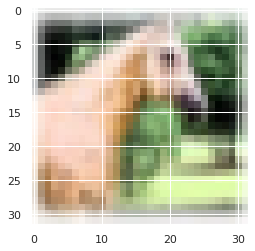

In [4]:
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [100]:
from info_nas.datasets.transforms import get_label_transforms

fixed_label = None
label_transforms = get_label_transforms(fixed_label=fixed_label)

In [101]:
from info_nas.datasets.io_dataset import IODataset

In [55]:
from info_nas.datasets.search_spaces.nasbench101 import Nasbench101Data
from info_nas.models.vae.arch2vec import Arch2vecPreprocessor
from searchspace_train.datasets.nasbench101 import load_nasbench


nb = load_nasbench('../../nasbench101.pickle')
prepro = Arch2vecPreprocessor()

net_data = Nasbench101Data(nb, prepro, debug=True)

In [102]:
from info_nas.datasets.io_dataset import IOData

io_dataset = IODataset(list(io['networks'].keys()), net_data, IOData(data=io), label_transform=label_transforms)

In [103]:
io_dataset.load()

In [104]:
outputs = [i['outputs'].numpy() for i in io_dataset]
outputs = np.array(outputs)
outputs.shape

(20000, 513)

In [105]:
labels = [i['labels'].numpy() for i in io_dataset]
labels = np.array(labels)
labels.shape

(20000,)

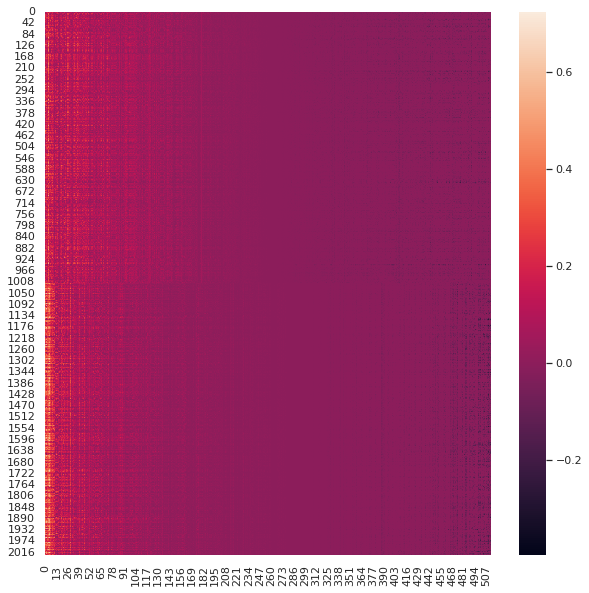

In [109]:
plt.figure(figsize=(10,10))
sns.heatmap(outputs[labels == 0])#, vmin=0.0, vmax=1.0)
plt.show()

## Test if sorting ok

In [110]:
from info_nas.datasets.transforms import IncludeBias

io_dataset_notr = IODataset(list(io['networks'].keys()), net_data, IOData(data=io), label_transform=IncludeBias())
io_dataset_notr.load()

In [111]:
first_label = next(iter(io_dataset_notr))['labels'].item() if fixed_label is None else fixed_label

# get weights and add bias
first_weights = next(iter(io_dataset_notr))['weights'].detach().numpy()[first_label]
bias = next(iter(io_dataset_notr))['biases'].detach().numpy()[first_label]
first_weights = np.hstack([first_weights, bias])

first_output = next(iter(io_dataset_notr))['outputs'].numpy()
first_output.shape

(513,)

In [112]:
weight_ids = np.argsort(first_weights)[::-1]
sorted_weights = first_weights[weight_ids]
sorted_outs = first_output[weight_ids]

mult_outs = sorted_outs * sorted_weights
assert (outputs[0] == mult_outs).all()

## Test arch2vec prepro

In [39]:
keys = io['networks'].keys()

for k in keys:
    metrics = nb.get_metrics_from_hash(k)
    print([m['final_test_accuracy'] for m in metrics[1][108]])

[0.9211738705635071, 0.9190705418586731, 0.9215745329856873]
[0.9195713400840759, 0.91015625, 0.9189703464508057]
